In [1]:
import sys, os
sys.path.insert(0, os.getcwd()+'/..')

import numpy as np
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
from PIL import Image
import caffe
from caffe import layers as L
from caffe import params as P

from DataLoader import load_cifar
%matplotlib inline

caffe.set_mode_gpu()
caffe.set_device(0)

load_cifar(datapath = '../Data')
print 'ok'


def cnn(hdf5, batch_size):
    n = caffe.NetSpec()
    n.data, n.label_coarse, n.label_fine = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=3)
    
    n.conv1 = L.Convolution(n.data, kernel_size=4, num_output=64, weight_filler=dict(type='xavier'))
    n.cccp1a = L.Convolution(n.conv1, kernel_size=1, num_output=42, weight_filler=dict(type='xavier'))
    n.relu1a = L.ReLU(n.cccp1a, in_place=True)
    n.cccp1b = L.Convolution(n.relu1a, kernel_size=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.cccp1b, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.drop1 = L.Dropout(n.pool1, in_place=True)
    n.relu1b = L.ReLU(n.drop1, in_place=True)
    
    n.conv2 = L.Convolution(n.relu1b, kernel_size=4, num_output=42, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    n.drop2 = L.Dropout(n.pool2, in_place=True)
    n.relu2 = L.ReLU(n.drop2, in_place=True)
    
    n.conv3 = L.Convolution(n.relu2, kernel_size=2, num_output=64, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    n.relu3 = L.ReLU(n.pool3, in_place=True)
    
    n.ip1 = L.InnerProduct(n.relu3, num_output=768, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.ip1, in_place=True)
    
    n.ip_c = L.InnerProduct(n.sig1, num_output=20, weight_filler=dict(type='xavier'))
    n.accuracy_c = L.Accuracy(n.ip_c, n.label_coarse)
    n.loss_c = L.SoftmaxWithLoss(n.ip_c, n.label_coarse)
    
    n.ip_f = L.InnerProduct(n.sig1, num_output=100, weight_filler=dict(type='xavier'))
    n.accuracy_f = L.Accuracy(n.ip_f, n.label_fine)
    n.loss_f = L.SoftmaxWithLoss(n.ip_f, n.label_fine)
    
    return n.to_proto()
    

def lenet(hdf5, batch_size):
    n = caffe.NetSpec()
    n.data, n.label_coarse, n.label_fine = L.HDF5Data(batch_size=batch_size, source=hdf5, ntop=3)
    
    
    n.conv1 = L.Convolution(n.data, kernel_size=3, num_output=48, weight_filler=dict(type='xavier'))
    n.cccp1a = L.Convolution(n.conv1, kernel_size=1, num_output=42, weight_filler=dict(type='xavier'))
    n.relu1a = L.ReLU(n.cccp1a, in_place=True)
    n.cccp1b = L.Convolution(n.relu1a, kernel_size=1, num_output=32, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.relu1a, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.drop1 = L.Dropout(n.pool1, in_place=True)
    #n.relu1b = L.ReLU(n.drop1, in_place=True)
    
    n.conv2 = L.Convolution(n.drop1, kernel_size=4, num_output=42, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=3, stride=2, pool=P.Pooling.MAX)
    #n.drop2 = L.Dropout(n.pool2, in_place=True)
    n.relu2 = L.ReLU(n.pool2, in_place=True)
    
    n.conv3 = L.Convolution(n.relu2, kernel_size=2, num_output=64, weight_filler=dict(type='xavier'))
    n.pool3 = L.Pooling(n.conv3, kernel_size=2, stride=2, pool=P.Pooling.AVE)
    #n.relu3 = L.ReLU(n.pool3, in_place=True)
    
    n.ip1 = L.InnerProduct(n.pool3, num_output=350, weight_filler=dict(type='xavier'))
    n.sig1 = L.Sigmoid(n.ip1, in_place=True)
    
    #n.ip_c = L.InnerProduct(n.sig1, num_output=20, weight_filler=dict(type='xavier'))
    #n.accuracy_c = L.Accuracy(n.ip_c, n.label_coarse)
    #n.loss_c = L.SoftmaxWithLoss(n.ip_c, n.label_coarse)
    
    n.ip_f = L.InnerProduct(n.sig1, num_output=100, weight_filler=dict(type='xavier'))
    n.accuracy_f = L.Accuracy(n.ip_f, n.label_fine)
    n.loss_f = L.SoftmaxWithLoss(n.ip_f, n.label_fine)
    
    
    return n.to_proto()



import h5py
def balance_data(dataset = '../Data/cifar-100/train.h5', num_per_class = 100):
    h5 = h5py.File(dataset, 'r')
    data = h5['data'][:]
    labels = h5['label_fine'][:]
    coarse = h5['label_coarse'][:]
    sorted_labels = np.sort(labels)
    indices = np.argsort(labels)
    old_class = sorted_labels[0]
    counter=0
    idx=0
    new_data = np.zeros([100*num_per_class, 3, 32, 32], np.float64)
    new_labels = np.zeros(100*num_per_class, np.float64)
    new_coarse = np.zeros(100*num_per_class, np.float64)
    for i in range (1, np.size(labels)):
        current_class = sorted_labels[i]
        if (counter < num_per_class):
            new_data[idx,:, :, :] = data[indices[i], :, :, :]
            new_labels[idx] = labels[indices[i]]
            new_coarse[idx] = coarse[indices[i]]
            counter = counter + 1
            idx += 1
        if current_class != old_class:
            counter = 0
        old_class = current_class
    new_path = dataset+str(num_per_class)
    print new_path
    with h5py.File(new_path, 'w') as hf:
        hf.create_dataset('data', data=new_data)
        hf.create_dataset('label_fine', data=new_labels)
        hf.create_dataset('label_coarse', data=new_coarse)

def feed_data(num_per_class):
    with open('cnn_train.prototxt', 'w') as f:
        f.write(str(cnn('train{}.txt'.format(num_per_class), 128)))
    
    with open('cnn_test.prototxt', 'w') as f:
        f.write(str(cnn('test{}.txt'.format(num_per_class), 128)))
        
#balance_data(dataset = '../Data/cifar-100/train.h5', num_per_class = 100)
#balance_data(dataset = '../Data/cifar-100/test.h5', num_per_class = 100)

#balance_data(dataset = '../Data/cifar-100/train.h5', num_per_class = 300)
#balance_data(dataset = '../Data/cifar-100/test.h5', num_per_class = 300)


from subprocess import call
def change_solver(optimizer='RMSProp', max_iter = 100, momentum = 0.0, path = '',
                  lr = 0.0006, lr_policy = 'inv', stepsize = 10000, gamma = 0.0001, wd = 0.001):
    global solver
    call(
'''echo "train_net: 'cnn_train.prototxt'
test_net: 'cnn_test.prototxt'

test_iter: 0
test_interval: {1}
test_compute_loss: false

base_lr: {5}
lr_policy: '{8}'
momentum: {3}
gamma: {6}
stepsize: {9}
weight_decay: {7}
power: 0.75

display: 0

max_iter: {1}

snapshot: {2}
snapshot_prefix: '{4}snapshot'

type: '{0}'" > new_solver.prototxt'''.format(optimizer, max_iter+1, max_iter, momentum, 
                                             path, lr, gamma, wd, lr_policy, stepsize),
            shell=True
        )
    solver = caffe.get_solver('new_solver.prototxt')
#base_lr: 0.01
#momentum: 0.9
#weight_decay: 0.0005
#rms_decay: 0.98
#solver_mode: GPU


from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from time import time

def plot_accuracy_loss(train_loss, test_loss, test_acc, path, timestamps, test_interval):  
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)
    par2 = host.twinx()

    new_fixed_axis = par2.get_grid_helper().new_fixed_axis
    par2.axis["right"] = new_fixed_axis(loc="right", axes=par2)
    par2.axis["right"].toggle(all=True)
    
    host.set_xlabel("Iterations")
    host.set_ylabel("Test accuracy")
    par2.set_ylabel("Loss")
    
    def time_to_str(T):
        return [str(int(t/60)) for t in T]
    
    ax2 = host.twiny()
    ax2.set_xlabel('Time in minutes')
    timestamps = timestamps[::len(timestamps)//10+1]
    ax2.set_xticks(timestamps)
    ax2.set_xticklabels(time_to_str(timestamps))
    
    xs = np.array(range(len(test_acc)))*test_interval
    p1, = host.plot(xs, test_acc, label="Test accuracy")
    p2, = par2.plot(xs, train_loss, label="Train loss")
    p3, = par2.plot(xs, test_loss, label="Test loss")
    
    host.set_ylim(0,1)
    host.legend()

    host.axis["left"].label.set_color(p1.get_color())
    plt.title(path, y=1.14)
    
    fig1 = plt.gcf()
    
    plt.show()
    plt.draw()
    fig1.savefig("{0}{1}".format(path, randint(1,100000)), dpi=100)

    
def run_solver(niter, path):
    if niter < 500:
        test_interval = 100
    else:
        test_interval = int(niter/100.0)
    output_len = int(np.ceil(niter * 1.0 / test_interval))

    train_loss = np.zeros(output_len)
    test_loss = np.zeros(output_len)
    test_acc = np.zeros(output_len)
    timestamps = np.zeros(output_len)
    
    t0 = time()    

    for it in range(niter):
        solver.step(1)
        
        if it % test_interval == 0:
            st = it // test_interval
            train_loss[st] = solver.net.blobs['loss_f'].data
            # store the output on the first test batch
            # (start the forward pass at conv1 to avoid loading new data)
            solver.test_nets[0].forward(start='conv1')

            #print 'Iteration', it*test_interval, 'testing...'
            correct = 0
            for test_it in range(100):
                solver.test_nets[0].forward()
                correct += sum(solver.test_nets[0].blobs['ip_f'].data.argmax(axis=1)
                               == solver.test_nets[0].blobs['label_fine'].data)
            test_acc[st] = correct / 1e4
            test_loss[st] = solver.test_nets[0].blobs['loss_f'].data
            timestamps[st] = time() - t0
    plot_accuracy_loss(train_loss, test_loss, test_acc, path, timestamps, test_interval)
    return train_loss, test_loss, test_acc, path, timestamps, test_interval


def pipeline(path = 'experiments/RMSProp/', optimizer='RMSProp', momentum = 0.0, max_iter = 10000,
             lr = 0.01, lr_policy = "inv", stepsize = 10000, gamma = 0.0001, wd = 0.001, num_per_class = None):
    if num_per_class:
        feed_data(num_per_class)
    snap_path = "{0}-snapshot_iter_{1}.solverstate".format(path, max_iter)
    if False:#os.path.exists(snap_path):
        print snap_path
        solver.restore(snap_path)
    else:
        change_solver(optimizer=optimizer, max_iter = max_iter, momentum = momentum, lr = lr, 
                      lr_policy = lr_policy, stepsize = stepsize, gamma = gamma, wd = wd, path = path)
    run_solver(max_iter, path)
    print path, 'done'

    
with open('cnn_train.prototxt', 'w') as f:
    f.write(str(cnn('train.txt', 128)))
    
with open('cnn_test.prototxt', 'w') as f:
    f.write(str(cnn('test.txt', 128)))

net = caffe.Net('cnn_train.prototxt',
                'cnn_snapshot_iter_150000.caffemodel',
                caffe.TEST)
solver = caffe.get_solver('cnn_solver_rms.prototxt')
solver.restore('cnn_snapshot_iter_150000.solverstate')
# -snapshot model_iter_1000.solverstate
#!$CAFFE_ROOT/build/tools/caffe train -solver cnn_solver_rms.prototxt
#!$CAFFE_ROOT/build/tools/caffe test -model cnn_test.prototxt -weights cnn_snapshot_iter_1000.caffemodel -iterations

print("Layers' features:")
print [(k, v.data.shape) for k, v in solver.net.blobs.items()]

print("Parameters and shape:")
print [(k, v[0].data.shape) for k, v in solver.net.params.items()]

!cat cnn_solver_rms.prototxt

ok
Layers' features:
[('data', (128, 3, 32, 32)), ('label_coarse', (128,)), ('label_fine', (128,)), ('label_coarse_data_1_split_0', (128,)), ('label_coarse_data_1_split_1', (128,)), ('label_fine_data_2_split_0', (128,)), ('label_fine_data_2_split_1', (128,)), ('conv1', (128, 64, 29, 29)), ('cccp1a', (128, 42, 29, 29)), ('cccp1b', (128, 32, 29, 29)), ('pool1', (128, 32, 14, 14)), ('conv2', (128, 42, 11, 11)), ('pool2', (128, 42, 5, 5)), ('conv3', (128, 64, 4, 4)), ('pool3', (128, 64, 2, 2)), ('ip1', (128, 768)), ('ip1_sig1_0_split_0', (128, 768)), ('ip1_sig1_0_split_1', (128, 768)), ('ip_c', (128, 20)), ('ip_c_ip_c_0_split_0', (128, 20)), ('ip_c_ip_c_0_split_1', (128, 20)), ('accuracy_c', ()), ('loss_c', ()), ('ip_f', (128, 100)), ('ip_f_ip_f_0_split_0', (128, 100)), ('ip_f_ip_f_0_split_1', (128, 100)), ('accuracy_f', ()), ('loss_f', ())]
Parameters and shape:
[('conv1', (64, 3, 4, 4)), ('cccp1a', (42, 64, 1, 1)), ('cccp1b', (32, 42, 1, 1)), ('conv2', (42, 32, 4, 4)), ('conv3', (64, 42,

In [3]:
%%time

max_iter = 4000

#pipeline(path = 'experiments/AdaGrad/', optimizer='AdaGrad', max_iter = max_iter)
  
#pipeline(path = 'experiments/Nesterov', optimizer='Nesterov', momentum = 0.9, max_iter = max_iter, 
#         lr = 0.0001, lr_policy = "step", gamma = 0.8, stepsize = 8000, wd = 0.005)

#pipeline(path = 'experiments/SGD/', optimizer='SGD', momentum = 0.9, max_iter = max_iter)

#pipeline(path = 'experiments/RMSProp/', optimizer='RMSProp', max_iter = max_iter) # may require RMSdecay back to 0.98

#pipeline(path = 'experiments/100/', optimizer='RMSProp', max_iter = max_iter, num_per_class = 100)

#pipeline(path = 'experiments/300/', optimizer='RMSProp', max_iter = max_iter, num_per_class = 300)

#feed_data('')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


In [5]:
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='Greys',  interpolation='nearest')

In [3]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

solver.net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image('cat.jpg'))
out = solver.net.forward()
out

{'accuracy_c': array(0.625, dtype=float32),
 'accuracy_f': array(0.5625, dtype=float32),
 'loss_c': array(1.1192748546600342, dtype=float32),
 'loss_f': array(1.6498193740844727, dtype=float32)}

In [7]:
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (64, 3, 4, 4)),
 ('cccp1a', (42, 64, 1, 1)),
 ('cccp1b', (32, 42, 1, 1)),
 ('conv2', (42, 32, 4, 4)),
 ('conv3', (64, 42, 2, 2)),
 ('ip1', (768, 256)),
 ('ip_c', (20, 768)),
 ('ip_f', (100, 768))]

In [9]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (128, 3, 32, 32)),
 ('label_coarse', (128,)),
 ('label_fine', (128,)),
 ('label_coarse_data_1_split_0', (128,)),
 ('label_coarse_data_1_split_1', (128,)),
 ('label_fine_data_2_split_0', (128,)),
 ('label_fine_data_2_split_1', (128,)),
 ('conv1', (128, 64, 29, 29)),
 ('cccp1a', (128, 42, 29, 29)),
 ('cccp1b', (128, 32, 29, 29)),
 ('pool1', (128, 32, 14, 14)),
 ('conv2', (128, 42, 11, 11)),
 ('pool2', (128, 42, 5, 5)),
 ('conv3', (128, 64, 4, 4)),
 ('pool3', (128, 64, 2, 2)),
 ('ip1', (128, 768)),
 ('ip1_sig1_0_split_0', (128, 768)),
 ('ip1_sig1_0_split_1', (128, 768)),
 ('ip_c', (128, 20)),
 ('ip_c_ip_c_0_split_0', (128, 20)),
 ('ip_c_ip_c_0_split_1', (128, 20)),
 ('accuracy_c', ()),
 ('loss_c', ()),
 ('ip_f', (128, 100)),
 ('ip_f_ip_f_0_split_0', (128, 100)),
 ('ip_f_ip_f_0_split_1', (128, 100)),
 ('accuracy_f', ()),
 ('loss_f', ())]

(64, 3, 4, 4)


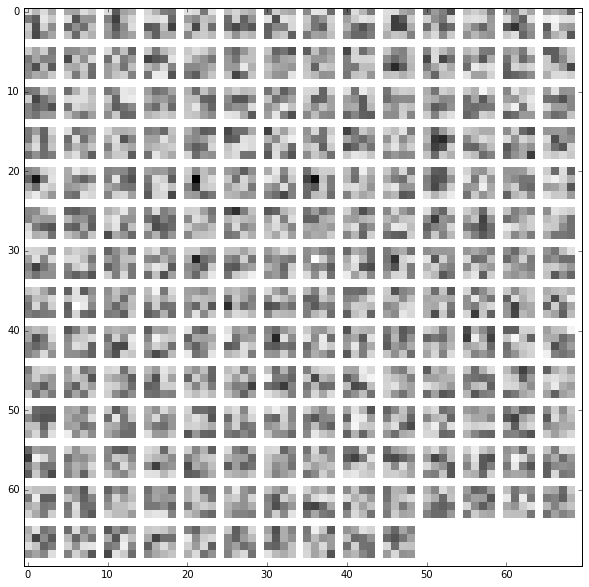

In [7]:
filters = solver.net.params['conv1'][0].data
print filters.shape
vis_square(filters.reshape(64*3,4,4))

(64, 29, 29)


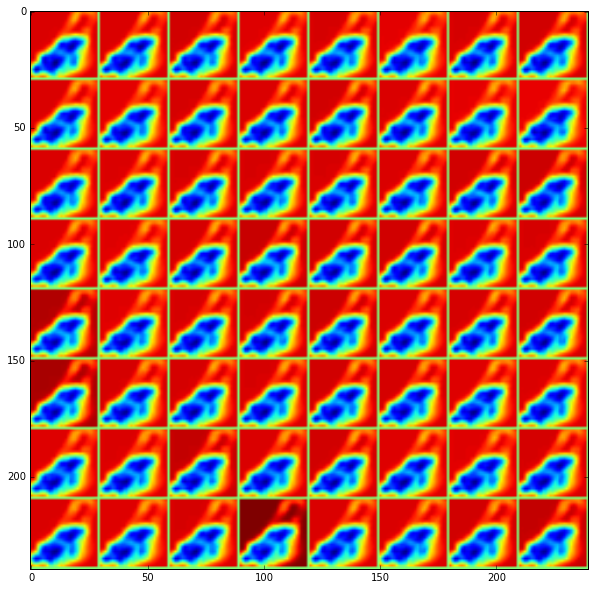

In [48]:
feat = net.blobs['conv1'].data[0]
print feat.shape
vis_square(feat.reshape(64,29,29), padval=0.5)

(42, 32, 4, 4)


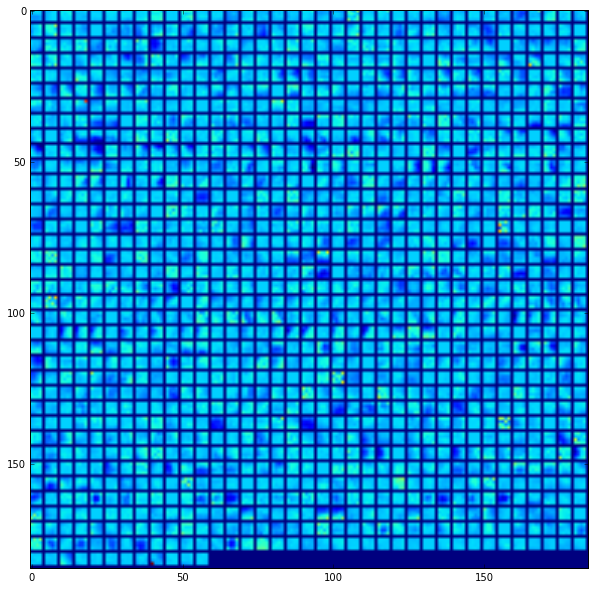

In [49]:
filters2 = net.params['conv2'][0].data
print filters2.shape
vis_square(filters2.reshape(42*32, 4, 4))

(42, 11, 11)


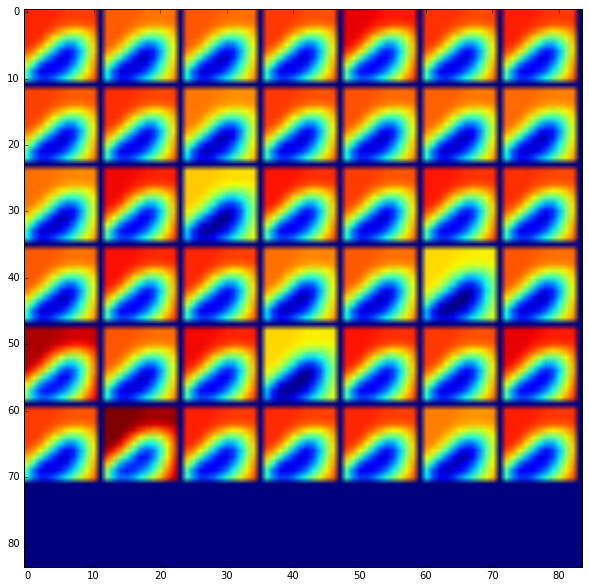

In [50]:
feat2 = net.blobs['conv2'].data[0]
print feat2.shape
vis_square(feat2.reshape(42,11,11))